# Setup
The code below is only needed if you are running the demo in colab. It installs a package to stream content on Google Colab.

**Note:** Make sure you have GPU enabled if you are running in colab.

Select Runtime > Change runtime type > Hardware accelerator: GPU


In [3]:
# VirtualHome 코드 수정 시 바로 반영하는 코드
%load_ext autoreload
%autoreload 2

In [4]:
import os
if 'google.colab' in str(get_ipython()):  # colab에서 돌릴 때만 필요한 코드. 실제 코랩에서 실행했을 때 requirements 설치에서 에러남
    print('Running on CoLab')
    osname = "linux"
    !pip install git+https://github.com/xavierpuigf/colabstreamer
    import colabstreamer
    colabstreamer.config_all()
    _xorg = colabstreamer.open_xorg()
    # Clone VirtualHome
    !git clone https://github.com/xavierpuigf/virtualhome.git
    %cd /content/virtualhome
    !pip install -r requirements.txt
else:   # local에서 할 때
    from sys import platform
    if platform == "darwin":
        osname = "macos"
    elif platform == "linux":
        osname = "linux"
    elif platform == "windows" or platform == 'win32':
        osname = "windows"

In [5]:
%cd demo

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'demo'
C:\Users\ACSL\Desktop\JW\virtualhome-master\virtualhome-master\virtualhome\demo


In [6]:
%pwd

'C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\demo'

# Imports

In [7]:
%matplotlib notebook
import IPython.display
import glob
from utils_demo import *
import pandas as pd
from sys import platform
import sys
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import shutil
import virtualhome
from unity_simulator.comm_unity import UnityCommunication
from unity_simulator import utils_viz

# Starting communication

The first step is to start a communication with the simulator. Make sure before you run this that you have downloaded the simulator, and placed it under the `simulation` folder. You will be interacting with the simulator with the communication `comm` created here. You can include the file name of the simulator or just call `UnityCommunication()` and manually open the executable.

Select `manual` if you are opening the executable separately, and `auto` if the unity executable is still not open.

Remember that if you are running this in a headless server, you will need to start a display in a separate terminal using:

```
sudo python helper_scripts/startx $DISPLAY_NUM
```

This is not needed if you are running a colab notebook.

In [8]:
mode = 'manual' # auto / manual -> 실행파일을 따로 열었으면 manual.
if mode == 'auto':
    if platform == 'darwin':
        exec_file = '../macos_exec*'
    else:
        exec_file = '../linux_exec*.x86_64'
    file_names = glob.glob(exec_file)
    if len(file_names) > 0:
        file_name = file_names[0]
        comm = UnityCommunication(file_name=file_name, port="8082", x_display="0")
    else:
        print("Error: executable path not found.")
else:
    comm = UnityCommunication()

In [9]:
comm.reset(36)

True

# Starting and Visualizing Scenes (동작 확인용)

After initalizing the simulation. We can interact with the environments provided in VirtualHome. The simulator is composed of 50 human designed apartments, a sample of environments can be seen here.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.39it/s]


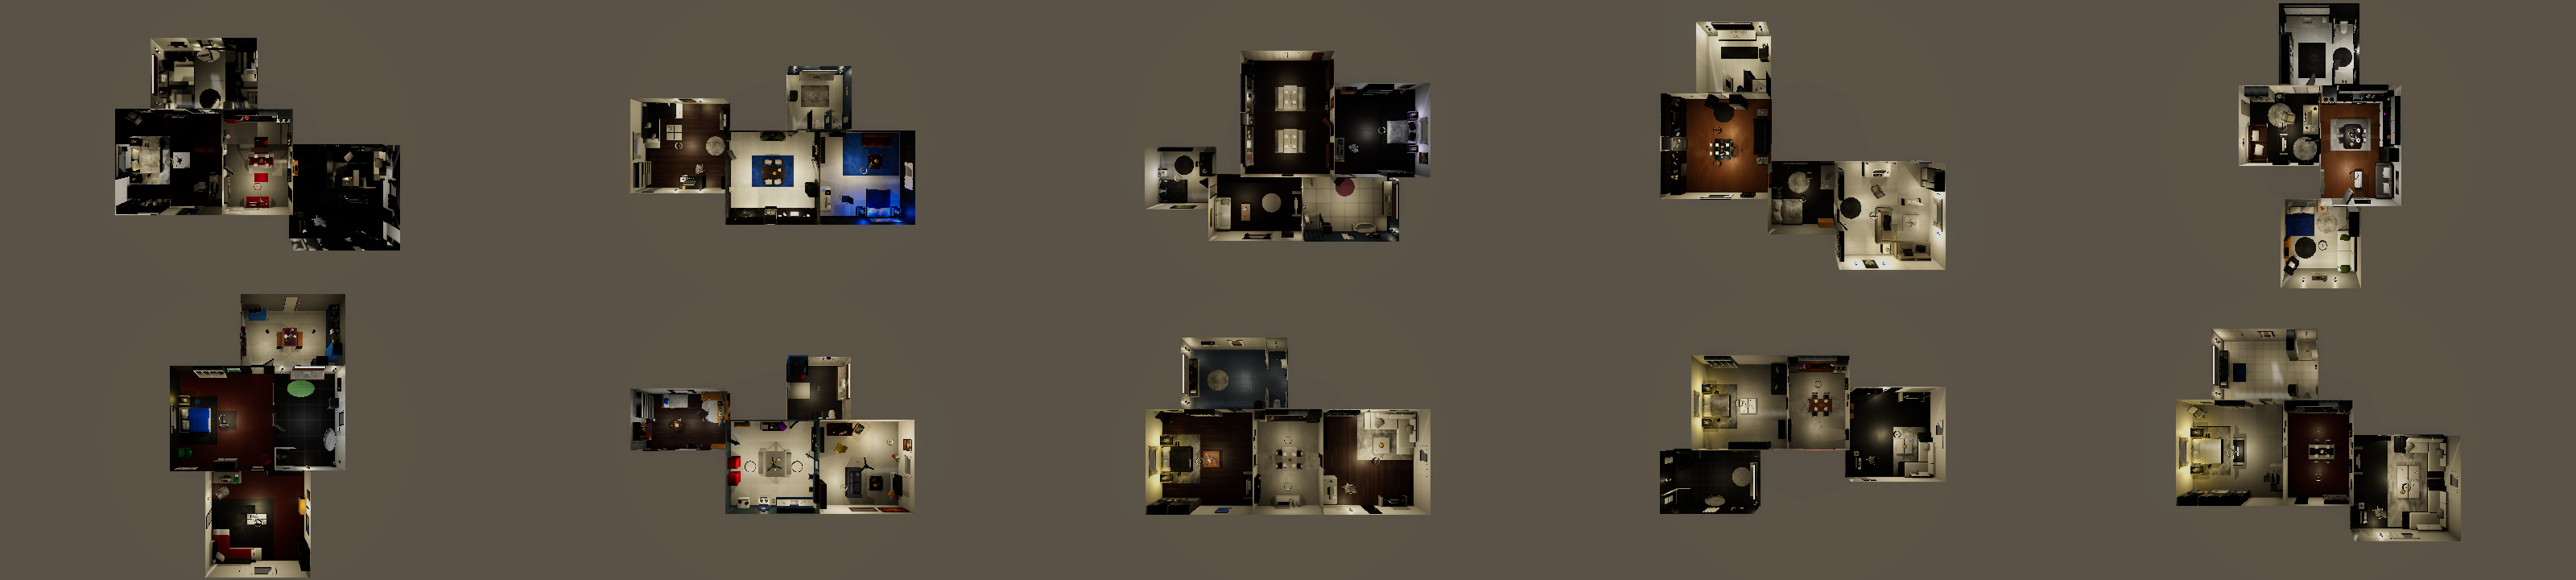

In [10]:
# The environments are numbered 0 to 50, let's visualize a few
views = []
for scene_id in tqdm(range(10)):
    comm.reset(scene_id)  #

    # We will go over the line below later
    comm.remove_terrain()
    top_view = get_scene_cameras(comm, [-1])
    views += top_view

IPython.display.display(display_grid_img(views, nrows=2))

# Procedural Generation (scene 다양화시 필요한 코드. 위 50개 scene에 대해 데이터 생성이 완료되고 난 후. 당장은 필요하지 않음)

VirtualHome also has support for procedural generation where we can generate completely new environments during runtime.

In [11]:
def set_action(who, action, object1=[], object2=[])->str:
    if len(object2)==0 and len(object1)!=0:
        return '<char{}> [{}] <{}> ({})'.format(str(who), str(action), str(object1[0]), str(object1[1]))
    elif len(object2)!=0 and len(object1)!=0:
        return '<char{}> [{}] <{}> ({}) <{}> ({})'.format(str(who), str(action), str(object1[0]), str(object1[1]), str(object2[0]), str(object2[1]))
    elif len(object2)==0 and len(object1)==0:
        return '<char{}> [{}]'.format(str(who), str(action))


In [44]:

import cv2
import numpy as np
import glob

import time

import os

def images_to_video(image_folder, video_name, fps=24):
    images = [img for img in os.listdir(image_folder) if img.endswith("normal.png")]
    images.sort()  # 파일명 순으로 정렬

    if not images:
        print("No PNG images found in the specified folder.")
        return

    frame = cv2.imread(os.path.join(image_folder, images[0]))
    print(frame.shape)
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    for image in images:
        img_path = os.path.join(image_folder, image)
        frame = cv2.imread(img_path)
        video.write(frame)

    cv2.destroyAllWindows()
    video.release()

def play_video(video_path):
    instance = cv2.VideoCapture(video_path)

    while True:
        ret, frame = instance.read()
        if not ret:
            break

        cv2.imshow('Video', frame)

        # 1ms마다 키 입력을 확인
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    instance.release()
    cv2.destroyAllWindows()

from openpyxl import load_workbook

wb = load_workbook("C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\graphs\\output.xlsx")

# Iterate over all worksheets in the workbook
for ws in wb.worksheets:
    def findExistString(searchString, text):
        if searchString in text:
            return True
        else:
            return False
    def findObExistString(searchString1, text1, searchString2, text2):
        if searchString1 in text1 and searchString2 in text2:
            return True
        else:
            return False


def setting(num, one, two, who): 
    s, g = comm.environment_graph()
    with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\graphs\\graph_' + str(num) + '.json', 'w') as f:
      json.dump(g, f, indent=4)

    # Add agents
    # 첫번째 agent는 로봇이라 가정하고 안보이는 agent로 세팅. 두번째 agent가 실제로 동작을 수행
    comm.add_character_camera(position=[0, 1.8, 0.15], rotation=[20, 0, 0], name='new_camera')
    comm.add_character('Chars/Male1_invisible', initial_room='{}'.format(one))
    comm.add_character('Chars/{}'.format(who), initial_room='{}'.format(two))

    # environment_graph g에서 필요한 object의 노드 id를 가져오는 코드
    kitchen_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'kitchen'][0]
    bathroom_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'bathroom'][0]
    livingroom_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'livingroom'][0]
    bedroom_id = [node['id'] for node in g['nodes'] if node['class_name'] == 'bedroom'][0]

    
    
    return bathroom_id, bedroom_id, kitchen_id, livingroom_id

# Generating Scripts (Multi-agent Actions)

The last step is to perform activities in them. We do this by defining scripts: Lists of instructions that will be executed in sequence. Each instruction contains an action, an object, and an id. The id should match with the `id` of each of the nodes in the environment graph.

We now want to execute the script in the environment. We do that through **render_script**. Notice that we can specify a file name, which will be used to save a video with the activity.

Other paramters to render_script are:
- script: a list of script lines
- randomize_execution: randomly choose elements
- random_seed: random seed to use when randomizing execution, -1 means that the seed is not set
- find_solution: find solution (True) or use graph ids to determine object instances (False)
- processing_time_limit: time limit for finding a solution
- skip_execution: skip rendering, only check if a solution exists
- output_folder: folder to output renderings, default is Output/
- file_name_prefix: prefix of created files (screenshots are put to output_folder/file_name_prefix/)
- frame_rate: frame rate
- capture_screenshot: save screenshots
- image_synthesis: save depth, segmentation, flow images
- save_pose_data: save pose data
- save_scene_states: save scene states
- character_resource: path to character resource to be used
- camera_mode: automatic (AUTO), first person (FIRST_PERSON), top (PERSON_TOP), front person view (PERSON_FRONT)

In [47]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(192, 'kitchen', 'bathroom', 'Female1')
  
num=0 #장면 번호
script = [     
    
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["tvstand", 183]),
    set_action(0, "walktowards", ["kitchentable", 184]),
    set_action(1, "walk", ["kitchen", kitchen_id]),
    set_action(1, "walk", ["kitchentable", 184]),
    set_action(1, "walk", ["cutleryknife", 213]),
    set_action(1, "grab", ["cutleryknife", 213]),
    set_action(1, "walk", ["cutleryfork", 214]),
    set_action(1, "grab", ["cutleryfork", 214]),
    set_action(1, "walk", ["sink", 196]),
    set_action(1, "putback", ["cutleryfork", 214], ["sink", 196]),
    set_action(1, "putback", ["cutleryknife", 213], ["sink", 196]),
    set_action(1, "switchon", ["faucet", 197]),
    



]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <bedroom> (69)
<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <tvstand> (183)
<char0> [walktowards] <kitchentable> (184)
<char1> [walk] <kitchen> (161)
<char1> [walk] <kitchentable> (184)
<char1> [walk] <cutleryknife> (213)
<char1> [grab] <cutleryknife> (213)
<char1> [walk] <cutleryfork> (214)
<char1> [grab] <cutleryfork> (214)
<char1> [walk] <sink> (196)
<char1> [putback] <cutleryfork> (214) <sink> (196)
<char1> [putback] <cutleryknife> (213) <sink> (196)
<char1> [switchon] <faucet> (197)


In [48]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [68]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(193, 'kitchen', 'bathroom', 'Female1')
  
num=1 #장면 번호
script = [     
    
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["tvstand", 183]),
    set_action(0, "walktowards", ["kitchencounter", 187]),
    set_action(1, "walk", ["kitchen", kitchen_id]),
    set_action(1, "walk",  ["kitchencounter", 187]),
    set_action(1, "walk",  ["milk", 244]),
    set_action(1, "grab",  ["milk", 244]),
    set_action(1, "walk",  ["microwave", 237]),
    set_action(1, "open",  ["microwave", 237]),
    set_action(1, "putin", ["milk", 244], ["microwave", 237]),
    set_action(1, "close", ["microwave", 237]),
    set_action(1, "switchon", ["microwave", 237]),
    set_action(1, "switchofff", ["microwave", 237]),
    set_action(1, "open",  ["microwave", 237]),
    set_action(1, "grab",  ["milk", 244]),
 
    



]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <bedroom> (69)
<char0> [walk] <bathroom> (11)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <tvstand> (183)
<char0> [walktowards] <kitchencounter> (187)
<char1> [walk] <kitchen> (161)
<char1> [walk] <kitchencounter> (187)
<char1> [walk] <milk> (244)
<char1> [grab] <milk> (244)
<char1> [walk] <microwave> (237)
<char1> [open] <microwave> (237)
<char1> [putin] <milk> (244) <microwave> (237)
<char1> [close] <microwave> (237)
<char1> [switchon] <microwave> (237)
<char1> [switchofff] <microwave> (237)
<char1> [open] <microwave> (237)
<char1> [grab] <milk> (244)


In [69]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [84]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(194, 'bathroom', 'bedroom', 'Female2')
  
num=2 #장면 번호
script = [     
    
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["closet", 104]),
    set_action(0, "walktowards", ["bookshelf", 101]),
    set_action(1, "run", ["bedroom", bedroom_id]),
    set_action(1, "walk", ["book", 117]),
    set_action(1, "grab", ["book", 117]),
    set_action(1, "walk", ["chair", 105]),
    set_action(0, "walktowards", ["chair", 105]),
    set_action(1, "sit", ["chair", 105]),
    set_action(1, "read", ["book", 117]),
    set_action(0, "walk", ["bathroom", bathroom_id]),
 
    



]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <bedroom> (69)
<char0> [walk] <closet> (104)
<char0> [walktowards] <bookshelf> (101)
<char1> [run] <bedroom> (69)
<char1> [walk] <book> (117)
<char1> [grab] <book> (117)
<char1> [walk] <chair> (105)
<char0> [walktowards] <chair> (105)
<char1> [sit] <chair> (105)
<char1> [read] <book> (117)
<char0> [walk] <bathroom> (11)


In [85]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [90]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(195, 'bathroom', 'bedroom', 'Female2')
  
num=3 #장면 번호
script = [     
    
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["closet", 104]),
    set_action(0, "walktowards", ["bookshelf", 101]),
    set_action(1, "run", ["bedroom", bedroom_id]),
    set_action(1, "walk", ["toy", 156]),
    set_action(1, "grab", ["toy", 156]),
    set_action(1, "walk", ["lightswitch", 107]),
    set_action(0, "walktowards", ["lightswitch", 107]),
    set_action(1, "switchoff", ["lightswitch", 107]),
    set_action(0, "walk", ["closet", 104]),
    set_action(0, "walktowards", ["bookshelf", 101]),
    set_action(1, "walk", ["toy", 157]),
    set_action(1, "grab", ["toy", 157]),
    set_action(1, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bathroom", bathroom_id]),
 
    



]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <bedroom> (69)
<char0> [walk] <closet> (104)
<char0> [walktowards] <bookshelf> (101)
<char1> [run] <bedroom> (69)
<char1> [walk] <toy> (156)
<char1> [grab] <toy> (156)
<char1> [walk] <lightswitch> (107)
<char0> [walktowards] <lightswitch> (107)
<char1> [switchoff] <lightswitch> (107)
<char0> [walk] <closet> (104)
<char0> [walktowards] <bookshelf> (101)
<char1> [walk] <toy> (157)
<char1> [grab] <toy> (157)
<char1> [walk] <livingroom> (245)
<char0> [walk] <bathroom> (11)


In [91]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [101]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(196, 'bedroom', 'bedroom', 'Female2')
  
num=4 #장면 번호
script = [     
    set_action(0, "walk", ["bathroom", bathroom_id]),
    set_action(0, "walk", ["toilet", 46]),
    set_action(0, "walktowards", ["sink", 37]),
    set_action(1, "walk", ["bathroom", bathroom_id]),
    set_action(1, "walk", ["towel", 49]),
    set_action(1, "grab", ["towel", 49]),
    set_action(1, "walk", ["sink", 37]),
    set_action(1, "putback", ["towel", 49], ["sink", 37]),
    set_action(1, "walk", ["lightswitch", 67]),
    set_action(0, "walktowards", ["lightswitch", 67]),
    set_action(1, "switchoff", ["lightswitch", 67]),
    set_action(1, "run", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bathroom> (11)
<char0> [walk] <toilet> (46)
<char0> [walktowards] <sink> (37)
<char1> [walk] <bathroom> (11)
<char1> [walk] <towel> (49)
<char1> [grab] <towel> (49)
<char1> [walk] <sink> (37)
<char1> [putback] <towel> (49) <sink> (37)
<char1> [walk] <lightswitch> (67)
<char0> [walktowards] <lightswitch> (67)
<char1> [switchoff] <lightswitch> (67)
<char1> [run] <kitchen> (161)
<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)


In [102]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [105]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(197, 'bedroom', 'bedroom', 'Male2')
  
num=5 #장면 번호
script = [     
    set_action(0, "walk", ["bathroom", bathroom_id]),
    set_action(0, "walk", ["toilet", 46]),
    set_action(0, "walktowards", ["sink", 37]),
    set_action(1, "walk", ["bathroom", bathroom_id]),
    set_action(1, "walk", ["waterglass", 56]),
    set_action(1, "grab", ["waterglass", 56]),
    set_action(0, "walk", ["sink", 37]),
    set_action(0, "walktowards", ["toilet", 46]),
    set_action(1, "walk", ["toilet", 46]),
    set_action(1, "open", ["toilet", 46]),
    set_action(1, "sit", ["toilet", 46]),
    set_action(1, "drink", ["waterglass", 56]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bathroom> (11)
<char0> [walk] <toilet> (46)
<char0> [walktowards] <sink> (37)
<char1> [walk] <bathroom> (11)
<char1> [walk] <waterglass> (56)
<char1> [grab] <waterglass> (56)
<char0> [walk] <sink> (37)
<char0> [walktowards] <toilet> (46)
<char1> [walk] <toilet> (46)
<char1> [open] <toilet> (46)
<char1> [sit] <toilet> (46)
<char1> [drink] <waterglass> (56)
<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)


In [106]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [128]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(198, 'livingroom', 'bedroom', 'Female4')
  
num=6 #장면 번호
script = [     
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bedroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["closet", 283]),
    set_action(0, "walktowards", ["coffeetable", 280]),
    set_action(1, "walk", ["livingroom", livingroom_id]),
    set_action(1, "walk", ["coffeetable", 280]),
    set_action(1, "grab", ["cellphone", 320]),
    set_action(1, "walk", ["bookshelf", 279]),
    set_action(0, "walktowards", ["bookshelf", 279]),
    set_action(1, "putback", ["cellphone", 320], ["bookshelf", 279]),
    set_action(1, "switchon", ["cellphone", 320]),
    set_action(1, "grab", ["magazine", 322]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <bathroom> (69)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <closet> (283)
<char0> [walktowards] <coffeetable> (280)
<char1> [walk] <livingroom> (245)
<char1> [walk] <coffeetable> (280)
<char1> [grab] <cellphone> (320)
<char1> [walk] <bookshelf> (279)
<char0> [walktowards] <bookshelf> (279)
<char1> [putback] <cellphone> (320) <bookshelf> (279)
<char1> [switchon] <cellphone> (320)
<char1> [grab] <magazine> (322)


In [129]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [134]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(199, 'livingroom', 'bedroom', 'Female4')
  
num=7 #장면 번호
script = [     
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bedroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["closet", 283]),
    set_action(0, "walktowards", ["coffeetable", 280]),
    set_action(1, "walk", ["livingroom", livingroom_id]),
    set_action(1, "walk", ["computer", 317]),
    set_action(1, "switchon", ["computer", 317]),
    set_action(1, "walk", ["lightswitch", 312]),
    set_action(1, "switchoff", ["lightswitch", 312]),
    set_action(1, "walk", ["desk", 281]),
    set_action(1, "grab", ["keyboard", 318]),
    set_action(1, "grab", ["mouse", 314]),
    set_action(1, "walk", ["kitchen", kitchen_id]),

]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <bathroom> (69)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <closet> (283)
<char0> [walktowards] <coffeetable> (280)
<char1> [walk] <livingroom> (245)
<char1> [walk] <computer> (317)
<char1> [switchon] <computer> (317)
<char1> [walk] <lightswitch> (312)
<char1> [switchoff] <lightswitch> (312)
<char1> [walk] <desk> (281)
<char1> [grab] <keyboard> (318)
<char1> [grab] <mouse> (314)
<char1> [walk] <kitchen> (161)


In [135]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [138]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(200, 'bathroom', 'bedroom', 'Female4')
  
num=8 #장면 번호
script = [     
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["desk", 281]),
    set_action(0, "walktowards", ["bookshelf", 279]),
    set_action(1, "walk", ["livingroom", livingroom_id]),
    set_action(1, "walk", ["bookshelf", 279]),
    set_action(1, "grab", ["notes", 331]),
    set_action(0, "walktowards", ["sofa", 278]),
    set_action(1, "walk", ["pillow", 308]),
    set_action(1, "grab", ["pillow", 308]),
    set_action(1, "walk", ["sofa", 278]),
    set_action(1, "sit", ["sofa", 278]),
    set_action(1, "read", ["notes", 331]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom_id]),


]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <desk> (281)
<char0> [walktowards] <bookshelf> (279)
<char1> [walk] <livingroom> (245)
<char1> [walk] <bookshelf> (279)
<char1> [grab] <notes> (331)
<char0> [walktowards] <sofa> (278)
<char1> [walk] <pillow> (308)
<char1> [grab] <pillow> (308)
<char1> [walk] <sofa> (278)
<char1> [sit] <sofa> (278)
<char1> [read] <notes> (331)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <bedroom> (69)
<char0> [walk] <bathroom> (11)


In [139]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


In [144]:
# Reset the scene
comm.activate_physics(gravity=-10)
comm.reset(38) # 괄호 안은 scene_id 넣기 0~49까지 다 했으면 아래 procedural_generation 코드로 대체!
# comm.procedural_generation(proc_gen_seed) # 괄호 안은 random seed 넣기. 일관성을 위해 0부터 해볼 것.
(bathroom_id, bedroom_id, kitchen_id, livingroom_id )=setting(201, 'bathroom', 'bedroom', 'Female4')
  
num=9 #장면 번호
script = [     
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["livingroom", livingroom_id]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["kitchen", kitchen_id]),
    set_action(0, "walk", ["fridge", 233]),
    set_action(0, "walktowards", ["tv", 205]),
    set_action(1, "run", ["kitchen", kitchen_id]),
    set_action(1, "walk", ["tv", 205]),
    set_action(1, "switchon", ["tv", 205]),
    set_action(1, "walk", ["kitchentable", 184]),
    set_action(1, "walk", ["chips", 240]),
    set_action(1, "grab", ["chips", 240]),
    set_action(1, "walk", ["salad ", 242]),
    set_action(1, "grab", ["salad ", 242]),
    set_action(1, "walk", ["tv", 205]),
    set_action(1, "drink", ["chips", 240]),
    set_action(0, "walk", ["bedroom", bedroom_id]),
    set_action(0, "walk", ["bathroom", bathroom_id]),


]
# 액션 하나마다 명렁어 수행하는 코드(file_name_prefix는 데이터마다 바꿔주기)
for i, script_instruction in enumerate(script):
    print(script_instruction)
    comm.render_script([script_instruction],
                       frame_rate=15,
                       recording=True,
                       image_synthesis=['normal', 'depth', 'seg_inst'],
                       skip_animation=False,
                       save_pose_data=True,
                       camera_mode=["new_camera"],
                       file_name_prefix='script{}'.format(str(num)))

    # s, graph = comm.environment_graph()  # 한 액션이 완료될 때마다 scene graph가 저장되게 하는 코드
    # with open('C:\\Users\\ACSL\\Desktop\\JW\\virtualhome\\virtualhome\\simulation\\build_camera\\Output\\script0\\0\\graph_' + str(i) + '.json', 'w') as f:
    #     json.dump(graph, f, indent=4)


<char0> [walk] <bedroom> (69)
<char0> [walk] <livingroom> (245)
<char0> [walk] <bedroom> (69)
<char0> [walk] <kitchen> (161)
<char0> [walk] <fridge> (233)
<char0> [walktowards] <tv> (205)
<char1> [run] <kitchen> (161)
<char1> [walk] <tv> (205)
<char1> [switchon] <tv> (205)
<char1> [walk] <kitchentable> (184)
<char1> [walk] <chips> (240)
<char1> [grab] <chips> (240)
<char1> [walk] <salad > (242)
<char1> [grab] <salad > (242)
<char1> [walk] <tv> (205)
<char1> [drink] <chips> (240)
<char0> [walk] <bedroom> (69)
<char0> [walk] <bathroom> (11)


In [145]:

if __name__ == "__main__":
    path='C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\script{}\\'.format(str(num))
    image_folder = str(path)+'0'
    video_name = str(path)+'output0.mp4'
    images_to_video(image_folder, video_name)
    play_video(video_name)
    image_folder = str(path)+'1'
    video_name = str(path)+'output1.mp4'
    images_to_video(image_folder, video_name)
    

(480, 640, 3)
(480, 640, 3)


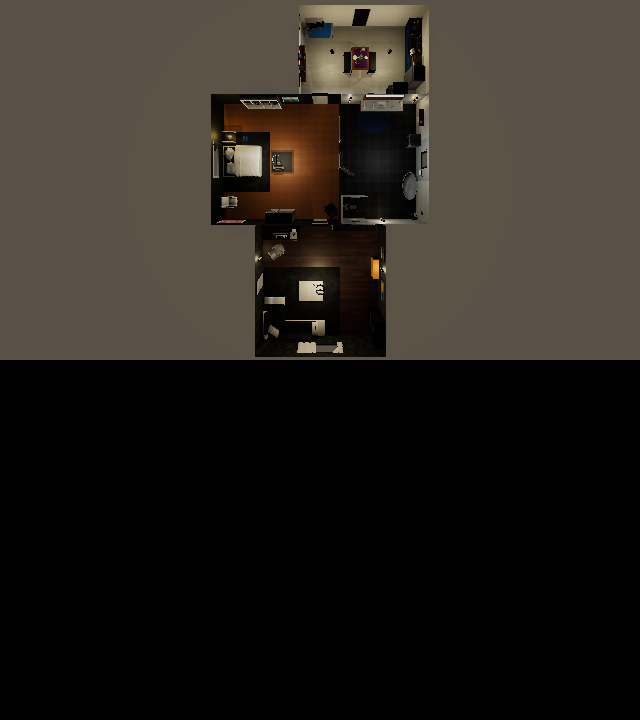

In [34]:
# The environments are numbered 0 to 50, let's visualize a few
views = []
comm.reset(38)  #
comm.remove_terrain()
top_view = get_scene_cameras(comm, [-1])
IPython.display.display(display_grid_img(top_view, nrows=2))

In [140]:
add_list=[]
# Lamps Props Ceiling Windows Walls Floor Appliances Electronics Rooms Furniture Food
for row in ws.iter_rows(): 
        if findObExistString("Food", row[1].value, "kitchentable", row[7].value): #7 2 5
            fine=str(row[0].value)+" "+str(row[2].value)+" "+str(row[5].value)+" "+str(row[7].value)
            if fine not in add_list:
               add_list.append(fine)
               print(add_list.pop())
        # if findExistString("Ceiling", row[1].value): #7 2
        #     print(row[0].value, row[2].value)

240 chips 184 kitchentable
242 salad 184 kitchentable


## (위에서 graph.json을 저장했을 경우) 액션이 끝날 때마다 scene graph 업데이트가 잘 이루어졌는지 확인하는 코드. 내용이 다르다고 하면 잘 업데이트 된 것)

In [21]:
# # 저장된 graph.json 파일들이 서로 같은지 비교하는 코드
# file1_path = '../build_camera/Output/script0/0/graph_2.json'
# file2_path = '../build_camera/Output/script0/0/graph_3.json'

# def compare_files(file1_path, file2_path):
#     with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
#         content1 = file1.read()
#         content2 = file2.read()

#     if content1 == content2:
#         print("두 파일의 내용이 동일합니다.")
#     else:
#         print("두 파일의 내용이 다릅니다.")

# compare_files(file1_path, file2_path)

import json
import os 
import openpyxl                                                                                                                                                                                               
#경로 수정할 것
os.chdir("C:\\Users\\ACSL\\Desktop\\JW\\virtualhome-master\\virtualhome-master\\virtualhome\\simulation\\build_camera\\Output\\graphs")


# JSON 파일 로드
with open('graph_192.json', 'r') as f:
    data = json.load(f)

# nodes와 edges 데이터 추출
nodes_data = data['nodes']
edges_data = data['edges']

# nodes 정보를 DataFrame으로 변환
df_nodes = pd.DataFrame(nodes_data)

# 필요한 nodes 컬럼만 선택
df_nodes = df_nodes[['id', 'category', 'class_name', 'prefab_name', 'properties']]

# edges 정보를 DataFrame으로 변환
df_edges = pd.DataFrame(edges_data)                                               

# edges에서 필요한 정보 추출
df_edges = df_edges[['from_id', 'to_id', 'relation_type']]

# 'to_id'에 해당하는 'class_name' 찾기
df_edges['to_class_name'] = df_edges['to_id'].map(df_nodes.set_index('id')['class_name'].to_dict())

# nodes와 edges 데이터 병합
df = pd.merge(df_nodes, df_edges, how='left', left_on='id', right_on='from_id')

# 필요한 column 순서로 재배치
df = df[['id', 'category', 'class_name', 'prefab_name', 'properties', 'to_id', 'relation_type', 'to_class_name']]

# 결과 출력
df.to_excel("output.xlsx", index=False, engine='xlsxwriter')


## Generating videos (생성된 프레임을 비디오로 만들고 싶을 때. 당장 필요한 코드는 아님)

In [ ]:
# Enter here the path to the video, it should be in the same location where you stored your executable
path_video = "../build_linux_camera/Output/"
utils_viz.generate_video(input_path=path_video,
                         prefix='script2',
                         char_id=0,
                         image_synthesis=['normal'],  #depth는 생성 안됨
                         frame_rate=20,
                         output_path=None) # None: output_path = input_path + '/' + prefix

# => 동영상이 중간에 잘리는건 프레임이 중간중간 빠져서!(ex. 103, 175 등. 이유는 모름). 프레임 복사해서 임의로 넣어봄

In [ ]:
display_vid('../build_linux_camera/Output/script1/video_normal.mp4')

In [ ]:
# Enter here the path to the video, it should be in the same location where you stored your executable
path_video = "../build_linux_camera/Output/"
utils_viz.generate_video(input_path=path_video,
                         prefix='script2',
                         char_id=0,
                         image_synthesis=['normal'],  #depth는 생성 안됨
                         frame_rate=20,
                         output_path=None) # None: output_path = input_path + '/' + prefix

# => 동영상이 중간에 잘리는건 프레임이 중간중간 빠져서!(ex. 103, 175 등. 이유는 모름). 프레임 복사해서 임의로 넣어봄

In [ ]:
display_vid('../build_linux_camera/Output/script1/video_normal.mp4')